# IBM Data Science Certification - Capstone Project - Week 3
## Segmenting and Clustering - Toronto Postal Code and Neighborhood
### Carlos Alexandre Nako

This notebook is for the Capstone Project as part of the IBM Data Science Certification to showcase how to use segmenting and clustering.

In [1]:
import pandas as pd
import numpy as np
!pip install bs4
import requests
from bs4 import BeautifulSoup

In [2]:
html_data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
beautiful_soup = BeautifulSoup(html_data.content, 'html.parser')
table_contents=[]
table=beautiful_soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [3]:
!pip install geocoder
import geocoder # import geocoder

In [5]:
g = geocoder.google('Toronto, Ontario')
g

<[REQUEST_DENIED] Google - Geocode [empty]>

#### Remark
Google Geocoding API is not free anymore.

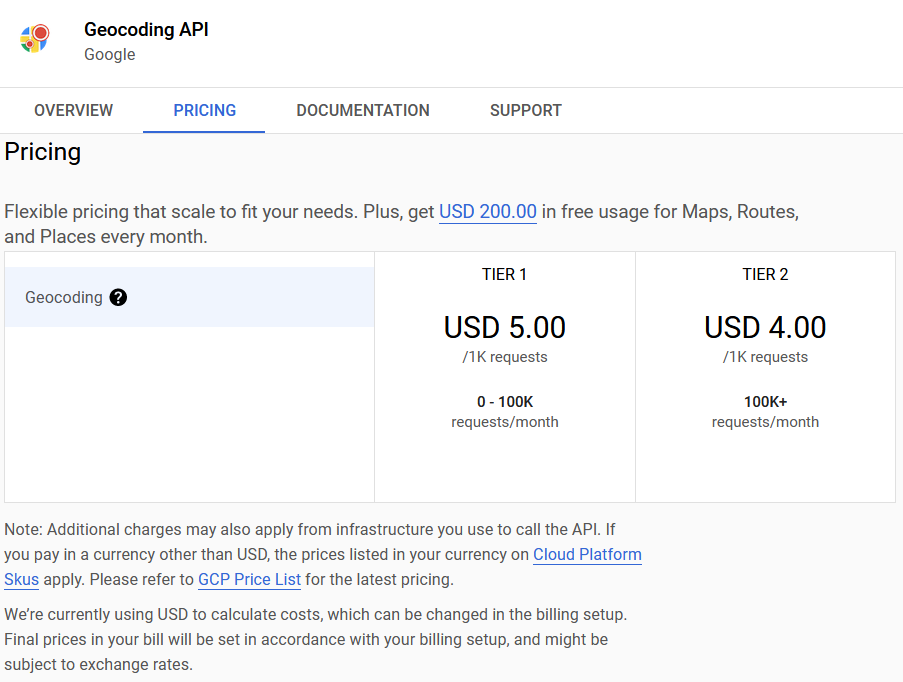

In [3]:
csv_path = 'https://cocl.us/Geospatial_data'
coord = pd.read_csv(csv_path)
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
Location = df.join(coord.set_index('Postal Code'),on='PostalCode')
Location.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Get Foursquare data for Toronto
Start by defining Foursquare Credential and Version

In [5]:
# The code was removed by Watson Studio for sharing.

Credentails Set: CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN


Get venue data from all Postal Codes

In [6]:
import json
from pandas.io.json import json_normalize

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
zip_size = Location.shape[0]
nearby_venues = pd.DataFrame()
venue_list = pd.DataFrame()
no_venue = pd.DataFrame(columns=['No ZIP'])

radius = 750
LIMIT = 100

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

for i in range(0,zip_size):

    PostalCode_latitude = Location.loc[i, 'Latitude'] # Postal Code latitude value
    PostalCode_longitude = Location.loc[i, 'Longitude'] # Postal Code longitude value
    PostalCode_ZIP = Location.loc[i, 'PostalCode'] # Postal Code value
    PostalCode_name = Location.loc[i, 'Neighborhood'] # neighborhood name


    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, PostalCode_latitude, PostalCode_longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = nearby_venues.iloc[0:0]
    nearby_venues = json_normalize(venues) # flatten JSON
    
    if len(nearby_venues) == 0:
        no_venue = no_venue.append({'No ZIP' : PostalCode_ZIP}, ignore_index=True)
    else:
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['PostalCode'] = PostalCode_ZIP
    
        venue_list = venue_list.append(nearby_venues, ignore_index=True)

        
venue_list.columns = [col.split(".")[-1] for col in nearby_venues.columns]
venue_list

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:25: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,PostalCode
0,Brookbanks Park,Park,43.751976,-79.332140,M3A
1,Variety Store,Food & Drink Shop,43.751974,-79.333114,M3A
2,DVP at York Mills,Intersection,43.758899,-79.334099,M3A
3,TTC Stop #09083,Bus Stop,43.759655,-79.332223,M3A
4,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,M4A
...,...,...,...,...,...
3650,Mr. Sub,Sandwich Place,43.622458,-79.521088,M8Z
3651,Tactical Products Canada,Miscellaneous Shop,43.626801,-79.529388,M8Z
3652,Performance Improvements,Automotive Shop,43.635205,-79.521983,M8Z
3653,Global Cheese,Cheese Shop,43.632339,-79.528567,M8Z


### Replicate analysis from previous exercise (NY clustering)
Complete Foursquare data with Location data

In [9]:
venue_list = venue_list.join(Location.set_index('PostalCode'),on='PostalCode')
venue_list.head()

,name,categories,lat,lng,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,Brookbanks Park,Park,43.751976,-79.332140,M3A,North York,Parkwoods,43.753259,-79.329656
1,Variety Store,Food & Drink Shop,43.751974,-79.333114,M3A,North York,Parkwoods,43.753259,-79.329656
2,DVP at York Mills,Intersection,43.758899,-79.334099,M3A,North York,Parkwoods,43.753259,-79.329656
3,TTC Stop #09083,Bus Stop,43.759655,-79.332223,M3A,North York,Parkwoods,43.753259,-79.329656
4,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,M4A,North York,Victoria Village,43.725882,-79.315572


#### Analyze each Postal Code
Organize data by Venue Categorie frequency per Postal Code

In [10]:
venue_onehot = pd.get_dummies(venue_list[['categories']], prefix="", prefix_sep="")

venue_onehot['PostalCode'] = venue_list['PostalCode'] 

fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_grouped = venue_onehot.groupby('PostalCode').mean().reset_index()
venue_grouped

,PostalCode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
98,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
99,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
100,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Rank venue categories per Postal Code

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['PostalCode'] = venue_grouped['PostalCode']

for ind in np.arange(venue_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Coffee Shop,Fast Food Restaurant,Hobby Shop,Home Service,African Restaurant,Paper / Office Supplies Store,Spa,Trail,Neighborhood,Opera House
1,M1C,Breakfast Spot,Bar,Burger Joint,Italian Restaurant,ATM,Optical Shop,Opera House,Office,Noodle House,Nightclub
2,M1E,Pizza Place,Fast Food Restaurant,Greek Restaurant,Sports Bar,Beer Store,Coffee Shop,Restaurant,Bank,Fried Chicken Joint,Salon / Barbershop
3,M1G,Coffee Shop,Park,Business Service,New American Restaurant,Other Great Outdoors,Organic Grocery,Optical Shop,Opera House,Office,Noodle House
4,M1H,Indian Restaurant,Bakery,Coffee Shop,Yoga Studio,Gym / Fitness Center,Convenience Store,Fried Chicken Joint,Burger Joint,Bus Line,Gas Station


Cluster Postal Codes into 10 clusters using k-means

In [13]:
from sklearn.cluster import KMeans

In [14]:
# set number of clusters
kclusters = 10

Toronto_grouped_clustering = venue_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 6, 2, 4, 2, 2, 2, 2, 7, 1], dtype=int32)

In [15]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Location
no_venue_size = no_venue.shape[0]

for i in range(0,no_venue_size):
    Toronto_merged.drop(no_venue['No ZIP'].index[i])

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(venues_sorted.set_index('PostalCode'), on='PostalCode')

Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,9.0,Food & Drink Shop,Park,Intersection,Bus Stop,ATM,Neighborhood,Optical Shop,Opera House,Office,Noodle House
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Hockey Arena,Playground,Financial or Legal Service,Sporting Goods Shop,Park,Pizza Place,Portuguese Restaurant,Coffee Shop,Plaza,Music School
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Italian Restaurant,Park,Theater,Restaurant,Café,Bakery,Pub,Thai Restaurant,Breakfast Spot
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Furniture / Home Store,Fast Food Restaurant,Vietnamese Restaurant,Coffee Shop,Restaurant,Dessert Shop,Cheese Shop,Sushi Restaurant,Gift Shop
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Park,Sushi Restaurant,Theater,Gastropub,Yoga Studio,Burrito Place


In [16]:
Toronto_merged = Toronto_merged.dropna(subset=['Cluster Labels'])
Toronto_merged['Cluster Labels'] = Toronto_merged['Cluster Labels'].astype(int)
Toronto_merged['Cluster Labels'].dtypes

dtype('int64')

Plot the cluster for Toronto

In [17]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37hafa7651_0
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2020
  - defaults/noarch::ibm-wsrt-py37main-main==custom=2020
done

# All requested packages already installed.



In [18]:
latitude = Location['Latitude'].mean()
longitude = Location['Longitude'].mean()

In [19]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters